# Sarcasm Detection in News Headlines

In [1]:
import json,random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

### Reading the dataset

In [3]:
ModelCheckpoint?

In [4]:
with open("Sarcasm_Headlines_Dataset_v2.json",encoding = 'utf8') as f:
    text = f.readlines()

In [5]:
headline = []
target = []

In [6]:
for data in text:
    line = json.loads(data.split('\n')[0])
    headline.append(line['headline'])
    target.append(line['is_sarcastic'])

In [7]:
headline[0]

'thirtysomething scientists unveil doomsday clock of hair loss'

In [8]:
target[0]

1

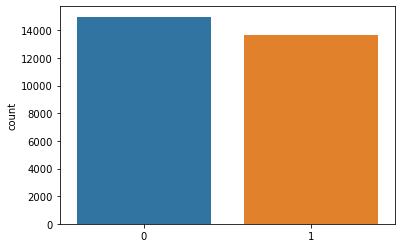

In [9]:
sns.countplot(target)

The dataset is balanced.

### Train-test split

In [21]:
dataset = list(zip(headline,target))
random.seed(10)
random.shuffle(dataset)

In [22]:
train = dataset[:25757]
test  = dataset[25757:]

In [23]:
X_train = list(zip(*train))[0]
y_train = list(zip(*train))[1]
X_test =list(zip(*test))[0]
y_test = list(zip(*test))[1]

In [24]:
len(X_train)

25757

In [25]:
len(X_test)

2862

### Text Preprocessing

In [26]:
tokenizer = Tokenizer(lower = True, oov_token = 'unk',num_words = 10000)
tokenizer.fit_on_texts(X_train)
vocab = tokenizer.word_index

In [27]:
max_len = 0
for line in X_train:
    max_len = max(max_len,len(line.split(' ')))

In [28]:
encoded_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(list(encoded_train), maxlen = 100,padding = 'post')

In [29]:
encoded_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(list(encoded_test), maxlen = 100,padding = 'post')

In [30]:
vocab_size = len(vocab)

### Transfer Learning - Convert words to vectors using GloVe Embeddings

In [31]:
word_vectors = {}
with open('glove.6B.50d.txt', encoding = 'utf-8') as f:
    for line in f.readlines():
        emb = line.split()
        word_vectors[emb[0]] = np.asarray(emb[1:],dtype = 'float')

In [32]:
def get_embedding_matrix():
    emb_dim = 50 #since we are using  50 D glove embeddings
    matrix = np.zeros((vocab_size+1,emb_dim))
    for word,idx in vocab.items():
        vector = word_vectors.get(word)
        if vector is not None:
            matrix[idx] = vector
    return matrix

In [33]:
embedding_matrix = get_embedding_matrix()

In [34]:
embedding_matrix.shape

(29369, 50)

### Model Architecture: Single LSTM

In [69]:
model_1 = Sequential()
model_1.add(Embedding(input_dim = vocab_size+1,output_dim = 50,mask_zero = True,input_length = 100,weights = [embedding_matrix],trainable = False))
model_1.add(LSTM(128))
model_1.add(Dense(1,activation = 'sigmoid'))

In [70]:
model_1.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = ['accuracy'])

In [71]:
checkpoint_1 = ModelCheckpoint('singleLSTM.h5', monitor = 'val_accuracy',save_best_only = True)
earlystop_1 = EarlyStopping(patience = 5,monitor = 'val_accuracy')

In [72]:
history = model_1.fit(X_train,np.array(y_train),validation_split=0.1,epochs = 10, verbose = 1, callbacks = [checkpoint_1,earlystop_1])

Epoch 1/10
725/725 [==============================] - 86s 119ms/step - loss: 0.5331 - accuracy: 0.7289 - val_loss: 0.4588 - val_accuracy: 0.7760
Epoch 2/10
725/725 [==============================] - 85s 117ms/step - loss: 0.4039 - accuracy: 0.8147 - val_loss: 0.3981 - val_accuracy: 0.8148
Epoch 3/10
725/725 [==============================] - 86s 119ms/step - loss: 0.3490 - accuracy: 0.8433 - val_loss: 0.3675 - val_accuracy: 0.8315
Epoch 4/10
725/725 [==============================] - 87s 119ms/step - loss: 0.3108 - accuracy: 0.8634 - val_loss: 0.3482 - val_accuracy: 0.8385
Epoch 5/10
725/725 [==============================] - 86s 118ms/step - loss: 0.2790 - accuracy: 0.8790 - val_loss: 0.3508 - val_accuracy: 0.8389
Epoch 6/10
725/725 [==============================] - 86s 119ms/step - loss: 0.2524 - accuracy: 0.8933 - val_loss: 0.3418 - val_accuracy: 0.8439
Epoch 7/10
725/725 [==============================] - 86s 119ms/step - loss: 0.2197 - accuracy: 0.9070 - val_loss: 0.3708 - val_ac

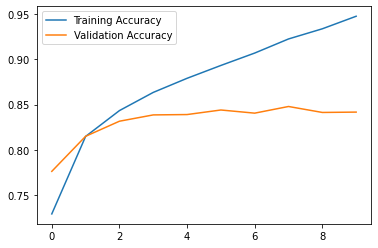

In [99]:
plt.plot(history.history['accuracy'],label = "Training Accuracy")
plt.plot(history.history['val_accuracy'],label = "Validation Accuracy")
plt.legend()
plt.show()

Training Accuracy keeps on increasing while Validation accuracy is Roughly 84%. Beyond 4-5 epochs, the model starts to overfit.

In [74]:
model_1.load_weights('singleLSTM.h5')

In [75]:
results = model_1.evaluate(X_test,np.array(y_test))
print("The accuracy on test data is ", results[1]*100)

90/90 [==============================] - 6s 66ms/step - loss: 0.3569 - accuracy: 0.8574
The accuracy on test data is  85.7442319393158


### Model Architecture: Single Bidirectional LSTM

In [76]:
model_2 = Sequential()
model_2.add(Embedding(input_dim = vocab_size+1,output_dim = 50,mask_zero = True,input_length = 100,weights = [embedding_matrix],trainable = False))
model_2.add(Bidirectional(LSTM(128)))
model_2.add(Dense(1,activation = 'sigmoid'))
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 50)           1468450   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               183296    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 1,652,003
Trainable params: 183,553
Non-trainable params: 1,468,450
_________________________________________________________________


In [77]:
model_2.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = ['accuracy'])

In [79]:
checkpoint_2 = ModelCheckpoint('biLSTM.h5', monitor = 'val_accuracy',save_best_only = True)
earlystop_2 = EarlyStopping(patience = 5,monitor = 'val_accuracy')

In [80]:
history_2 = model_2.fit(X_train,np.array(y_train),validation_split=0.1,epochs = 10, callbacks = [checkpoint_2,earlystop_2])

Epoch 1/10
725/725 [==============================] - 119s 164ms/step - loss: 0.5055 - accuracy: 0.7470 - val_loss: 0.4160 - val_accuracy: 0.8078
Epoch 2/10
725/725 [==============================] - 105s 144ms/step - loss: 0.3845 - accuracy: 0.8278 - val_loss: 0.3827 - val_accuracy: 0.8296
Epoch 3/10
725/725 [==============================] - 111s 153ms/step - loss: 0.3296 - accuracy: 0.8544 - val_loss: 0.3449 - val_accuracy: 0.8447
Epoch 4/10
725/725 [==============================] - 111s 153ms/step - loss: 0.2838 - accuracy: 0.8767 - val_loss: 0.3392 - val_accuracy: 0.8486
Epoch 5/10
725/725 [==============================] - 110s 152ms/step - loss: 0.2389 - accuracy: 0.9000 - val_loss: 0.3546 - val_accuracy: 0.8443
Epoch 6/10
725/725 [==============================] - 99s 137ms/step - loss: 0.1945 - accuracy: 0.9202 - val_loss: 0.3506 - val_accuracy: 0.8540
Epoch 7/10
725/725 [==============================] - 111s 152ms/step - loss: 0.1477 - accuracy: 0.9428 - val_loss: 0.4108 - 

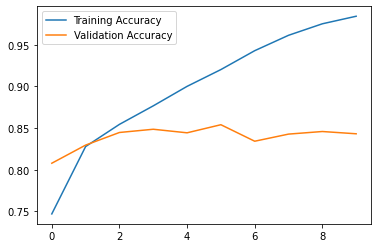

In [98]:
plt.plot(history_2.history['accuracy'],label = "Training Accuracy")
plt.plot(history_2.history['val_accuracy'],label = "Validation Accuracy")
plt.legend()
plt.show()

Best Validation accuracy is around 85%. Training accuracy has increased to 98%.

In [82]:
model_2.load_weights('biLSTM.h5')

In [83]:
results_2 = model_2.evaluate(X_test,np.array(y_test))

90/90 [==============================] - 7s 72ms/step - loss: 0.3643 - accuracy: 0.8473


In [84]:
print("Test accuracy is ",results_2[1]*100)

Test accuracy is  84.73095893859863


### Model Architecture: Stacked LSTM

In [85]:
model_3 = Sequential()
model_3.add(Embedding(input_dim = vocab_size+1,output_dim = 50,mask_zero = True,input_length = 100,weights = [embedding_matrix],trainable = False))
model_3.add(LSTM(128,return_sequences = True))
model_3.add(LSTM(128))
model_3.add(Dense(1,activation = 'sigmoid'))

In [86]:
model_3.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = ['accuracy'])

In [87]:
checkpoint_3 = ModelCheckpoint('stackedLSTM.h5', monitor = 'val_accuracy',save_best_only = True)
earlystop_3 = EarlyStopping(patience = 5,monitor = 'val_accuracy')

In [88]:
history_3 = model_3.fit(X_train,np.array(y_train),validation_split=0.1,epochs = 10,callbacks = [checkpoint_3,earlystop_3])

Epoch 1/10
725/725 [==============================] - 191s 263ms/step - loss: 0.5294 - accuracy: 0.7337 - val_loss: 0.4255 - val_accuracy: 0.8020
Epoch 2/10
725/725 [==============================] - 193s 266ms/step - loss: 0.3986 - accuracy: 0.8182 - val_loss: 0.4068 - val_accuracy: 0.8133
Epoch 3/10
725/725 [==============================] - 193s 266ms/step - loss: 0.3433 - accuracy: 0.8442 - val_loss: 0.3541 - val_accuracy: 0.8346
Epoch 4/10
725/725 [==============================] - 198s 273ms/step - loss: 0.3077 - accuracy: 0.8647 - val_loss: 0.3350 - val_accuracy: 0.8432
Epoch 5/10
725/725 [==============================] - 195s 268ms/step - loss: 0.2744 - accuracy: 0.8806 - val_loss: 0.3537 - val_accuracy: 0.8447
Epoch 6/10
725/725 [==============================] - 194s 267ms/step - loss: 0.2419 - accuracy: 0.8967 - val_loss: 0.3670 - val_accuracy: 0.8408
Epoch 7/10
725/725 [==============================] - 193s 266ms/step - loss: 0.2065 - accuracy: 0.9166 - val_loss: 0.3567 -

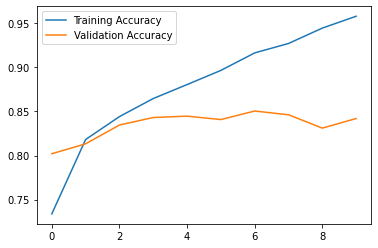

In [89]:
plt.plot(history_3.history['accuracy'],label = "Training Accuracy")
plt.plot(history_3.history['val_accuracy'],label = "Validation Accuracy")
plt.legend()
plt.show()

In [91]:
model_3.load_weights('stackedLSTM.h5')

In [92]:
results_3 = model_3.evaluate(X_test,np.array(y_test))
print("Test accuracy is ",results_3[1]*100)

90/90 [==============================] - 12s 138ms/step - loss: 0.3688 - accuracy: 0.8459
Test accuracy is  84.59119200706482


### Model Architecture : Stacked Bidirectional LSTM

In [93]:
model_4 = Sequential()
model_4.add(Embedding(input_dim = vocab_size+1,output_dim = 50,mask_zero = True,input_length = 100,weights = [embedding_matrix],trainable = False))
model_4.add(Bidirectional(LSTM(50,return_sequences = True)))
model_4.add(Bidirectional(LSTM(50)))
model_4.add(Dense(1,activation = 'sigmoid'))

In [94]:
model_4.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = ['accuracy'])

In [95]:
checkpoint_4 = ModelCheckpoint('stackedbiLSTM.h5', monitor = 'val_accuracy',save_best_only = True)
earlystop_4 = EarlyStopping(patience = 5,monitor = 'val_accuracy')

In [96]:
history_4 = model_4.fit(X_train,np.array(y_train),validation_split=0.1,epochs = 10, callbacks = [checkpoint_4,earlystop_4])

Epoch 1/10
725/725 [==============================] - 141s 195ms/step - loss: 0.5044 - accuracy: 0.7469 - val_loss: 0.4072 - val_accuracy: 0.8106
Epoch 2/10
725/725 [==============================] - 86s 119ms/step - loss: 0.3845 - accuracy: 0.8249 - val_loss: 0.3771 - val_accuracy: 0.8210
Epoch 3/10
725/725 [==============================] - 89s 123ms/step - loss: 0.3352 - accuracy: 0.8514 - val_loss: 0.3452 - val_accuracy: 0.8486
Epoch 4/10
725/725 [==============================] - 90s 124ms/step - loss: 0.2981 - accuracy: 0.8695 - val_loss: 0.3303 - val_accuracy: 0.8525
Epoch 5/10
725/725 [==============================] - 105s 145ms/step - loss: 0.2657 - accuracy: 0.8883 - val_loss: 0.3453 - val_accuracy: 0.8513
Epoch 6/10
725/725 [==============================] - 100s 138ms/step - loss: 0.2387 - accuracy: 0.9020 - val_loss: 0.3365 - val_accuracy: 0.8521
Epoch 7/10
725/725 [==============================] - 91s 125ms/step - loss: 0.2104 - accuracy: 0.9132 - val_loss: 0.3432 - val

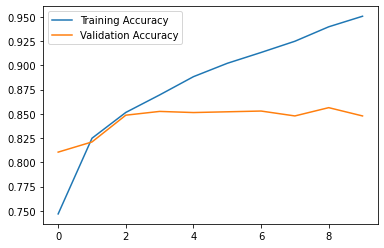

In [97]:
plt.plot(history_4.history['accuracy'],label = "Training Accuracy")
plt.plot(history_4.history['val_accuracy'],label = "Validation Accuracy")
plt.legend()
plt.show()

In [100]:
model_4.load_weights('stackedbiLSTM.h5')

In [101]:
model_4.evaluate(X_test,np.array(y_test))

90/90 [==============================] - 2s 26ms/step - loss: 0.4132 - accuracy: 0.8459 0s - loss: 0.4037 - accu


[0.41323697566986084, 0.8459119200706482]

### Conclusion

More or less, the best achieved accuracy is 85%. The models tend to overfit after some epochs.

### Future Work

- Alter the number of LSTM units.
- Effect of Dropout.
- Deploy a Web App using Flask.